<a href="https://colab.research.google.com/github/HaydenJF/CPSC392-Project1/blob/main/Project1_SP22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 1

[This dataset](https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/Proj1.csv) is adapted from the World Health Organization on Strokes (it's based on real data but is NOT REAL). Use this dataset to answer the following questions and perform the following tasks. Feel free to add extra cells as needed, but <strong>clearly identify where each question is answered, both the code and Markdown cells</strong>. Please remove any superflous code. Please put any written/typed responses in MARKDOWN CELLS.

## Data Information

- `reg_to_vote`: 0 if no, 1 if yes.
- `age`: age of the patient in years.
- `hypertension`: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension.
- `heart_disease`: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease.
- `ever_married`: 0 if no, 1 if yes.
- `Residence_type`: 0 for Rural, 1 for Urban.
- `avg_glucose_level`: average glucose level in blood.
- `bmi`: body mass index.
- `smoking_status_smokes`, `smoking_status_formerly`: Whether or not the person smokes, or formerly smoked. If a person has 0's for both these columns, they never smoked.
- `stroke`: 1 if the patient had a stroke or 0 if not.
- `dog_owner`: 0 if no, 1 if yes.
- `er_visits`: number of recorded Emergency Room visits in lifetime.
- `racoons_to_fight`: number of racoons the patient belives they could fight off at once.
- `fast_food_budget_month`: amount (in US dollars) spent on fast food per month.


## Part I: Logistic Regression
Build a logistic regression model to predict whether or not someone had a `stroke` based on **all** the other variables in the dataset.

1. Count the missing data per column, and remove rows with missing data (if any).
2. Use 10 fold cross validation for your model validation. Z-score your continuous variables only. Store both the train and test accuracies to check for overfitting. **Is the model overfit? How can you tell?**
3. After completing steps 1-2, fit another logistic regression model on ALL of the data (no model validation; but do z score) using the same predictors as before, and put the coefficients into a dataframe called `coef`.
4. print out a confusion matrix for the model you made in part 3. **What does this confusion matrix tell you about your model? How can you tell?**

## Part II: Data Exploration
The WHO has asked the following five questions, create **at least 1 ggplot graph per question** (using the above data + model when needed) to help answer each question, and **explicitly answer the question in a Markdown cell** below your graph. You may use other calculations to help support your answer but MUST pair it with a graph. Write your answer as if you were explaining it to a non-data scientist. You will be graded on the effectiveness and clarity of your graph, as well as the completeness, clarity, and correctness of your responses and justifications.

1. In this specific data set, do dog-owners over 50 have a higher average probability of stoke than non-dog owners who currently smoke? How can you tell? (Do not use the model for this question, it's asking you to compare the observed probability of having a stroke in the two groups described).
2. What is the relationship between average blood glucose and BMI? Is the relationship between those two variables different for people who are and are not registered to vote? How can you tell?
3. Is your logistic regression model most accurate for people who make less than 30k, between 30-90k, or over 90k? Discuss the potential accuracy *and* ethical implications if your model *were* more accurate for different groups (you can use the full model from part I-3 to check accuracy for each of these groups; DO NOT create/fit new models for each income range, use the model from part I-3 to calculate the accuracy for each of these groups.)
4. Which of the following variables is the strongest predictor of having a stroke (owning a dog, residence type, marriage, being registered to vote)? How were you able to tell?
5. Create a variable `er_visits_per_year` that calculates the # of visits to the ER that a person has had per year of life. Store this variable in your data frame (no need to include this variable in the previous logistic regression model). Is the # of ER visits per year different for stroke and non-stroke patients? How can you tell?

In [169]:
#imports
import warnings
warnings.filterwarnings('ignore')


import pandas as pd
import numpy as np
from plotnine import *

from sklearn.linear_model import LogisticRegression # Logistic Regression Model
from sklearn.preprocessing import StandardScaler #Z-score variables
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix
#model evaluation

from sklearn.model_selection import KFold # K-Fold

%matplotlib inline

db = pd.read_csv("https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/Proj1.csv")
db

,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,smoking_status_smokes,smoking_status_formerly,reg_to_vote,dog_owner,raccoons_to_fight,fast_food_budget_month,income_in_k,er_visits
0,60.0,1.0,0.0,0.0,1.0,73.00,25.2,0,1,0,1.0,1.0,10.0,209.19,51.553645,9.0
1,4.0,0.0,0.0,0.0,0.0,110.15,17.1,0,0,0,0.0,1.0,13.0,176.46,45.405414,5.0
2,77.0,0.0,0.0,1.0,1.0,68.38,27.8,0,0,0,0.0,1.0,6.0,213.00,94.865174,8.0
3,37.0,0.0,0.0,1.0,1.0,95.08,30.1,0,0,0,1.0,1.0,12.0,161.90,84.123775,8.0
4,44.0,0.0,0.0,0.0,0.0,103.78,40.9,0,1,0,1.0,1.0,11.0,261.29,74.794596,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,52.0,1.0,0.0,0.0,1.0,106.22,29.0,0,0,0,0.0,0.0,1.0,179.77,74.826197,9.0
14996,56.0,0.0,0.0,1.0,1.0,63.18,26.5,0,0,0,1.0,0.0,15.0,143.61,52.280949,16.0
14997,60.0,1.0,0.0,1.0,0.0,100.20,28.6,0,0,0,0.0,1.0,17.0,64.87,92.427118,24.0
14998,77.0,0.0,0.0,1.0,0.0,90.00,32.0,0,0,0,0.0,0.0,11.0,205.92,53.042139,6.0


## Part I: Logistic Regression

1. Count the missing data per column, and remove rows with missing data (if any).

In [170]:
print(db.isnull().sum())
db.dropna(inplace = True)
db = db.reset_index()
print(db.isnull().sum())


age                         13
hypertension                12
heart_disease               21
ever_married                 9
Residence_type              21
avg_glucose_level           31
bmi                        575
stroke                       0
smoking_status_smokes        0
smoking_status_formerly      0
reg_to_vote                 14
dog_owner                   21
raccoons_to_fight           27
fast_food_budget_month       8
income_in_k                 21
er_visits                   15
dtype: int64
index                      0
age                        0
hypertension               0
heart_disease              0
ever_married               0
Residence_type             0
avg_glucose_level          0
bmi                        0
stroke                     0
smoking_status_smokes      0
smoking_status_formerly    0
reg_to_vote                0
dog_owner                  0
raccoons_to_fight          0
fast_food_budget_month     0
income_in_k                0
er_visits                  

2. Use 10 fold cross validation for your model validation. Z-score your continuous variables only. Store both the train and test accuracies to check for overfitting. 

In [171]:
# Kfold

X = db[["reg_to_vote",
        "age", 
        "hypertension", 
        "heart_disease", 
        "ever_married", 
        "Residence_type", 
        "avg_glucose_level", 
        "bmi", 
        "smoking_status_smokes", 
        "smoking_status_formerly",
        "dog_owner",
        "er_visits",
        "raccoons_to_fight",
        "fast_food_budget_month", 
        "income_in_k"]]
        
X_continous = ["age", "avg_glucose_level", "bmi", "er_visits", 
               "raccoons_to_fight", "fast_food_budget_month", "income_in_k"]
y = db["stroke"]
lr = LogisticRegression()

kf = KFold(n_splits = 10, shuffle = True)

acc_test = []
acc_train = []

for train, test in kf.split(X):
    X_train = X.iloc[train]
    X_test  = X.iloc[test]
    y_train = y.iloc[train]
    y_test  = y.iloc[test]
    
    # z
    z = StandardScaler()
    
    z.fit(X_train[X_continous])
    
    X_train[X_continous] = z.transform(X_train[X_continous])
    X_test[X_continous] = z.transform(X_test[X_continous])
    
    # model
    model = lr.fit(X_train, y_train)
    
    # accuracy    
    acc_test.append(accuracy_score(y_test, model.predict(X_test)))
    acc_train.append(accuracy_score(y_train, model.predict(X_train)))

print("Train Case Accuracy:")
print(np.mean(acc_train))

print("Test Case Accuracy:")
print(np.mean(acc_test))





Train Case Accuracy:
0.9604525054447614
Test Case Accuracy:
0.9601319195495343


**Is the model overfit? How can you tell?**


It really doesn't look like it.  The accuracy of the test case and the train case were extremely similar.  Generally you can tell there is overfitting when the train case is much more accurate than the train case.  However, this is not happening here.  Both are getting consistent 96.0 scores.

3. After completing steps 1-2, fit another logistic regression model on ALL of the data (no model validation; but do z score) using the same predictors as before, and put the coefficients into a dataframe called `coef`.

In [172]:
X2_names = ["reg_to_vote",
        "age", 
        "hypertension", 
        "heart_disease", 
        "ever_married", 
        "Residence_type", 
        "avg_glucose_level", 
        "bmi", 
        "smoking_status_smokes", 
        "smoking_status_formerly",
        "dog_owner",
        "er_visits",
        "raccoons_to_fight",
        "fast_food_budget_month",
        "income_in_k"]

X2 = db[X2_names]
        
X_continous2 = ["age", "avg_glucose_level", "bmi", "er_visits", 
                "raccoons_to_fight", "fast_food_budget_month", "income_in_k"]
y2 = db["stroke"]

lr2 = LogisticRegression()
 
# z
z2 = StandardScaler()
    
z2.fit(X2[X_continous2])
    
X2[X_continous2] = z2.transform(X[X_continous2])
    
# model
model2 = lr2.fit(X2, y2)
    
coef = pd.DataFrame({"Coefs": lr2.coef_[0],
                     "Names": X2_names})

coef

,Coefs,Names
0,-0.059925,reg_to_vote
1,1.613121,age
2,0.249543,hypertension
3,0.423396,heart_disease
4,-0.187965,ever_married
5,-0.019790,Residence_type
6,0.242798,avg_glucose_level
7,0.111694,bmi
8,0.294617,smoking_status_smokes
9,0.145672,smoking_status_formerly


4. print out a confusion matrix for the model you made in part 3. 

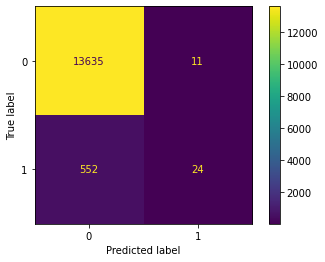

In [173]:
plot_confusion_matrix(lr2,X2, y2)


**What does this confusion matrix tell you about your model? How can you tell?**

The model tells us that it heavily favors picking no stroke even if that is inaccurate.  Although The accuracy of picking a 0 when the True value is 0 is in the 99%+, the accuracy for picking a 1 when the actual score is a 1 is really bad (like less than 5% bad).  This means that the logistic regression is severely underfitting by just choosing 0 for everything.

## Part II: Data Exploration
The WHO has asked the following five questions, create **at least 1 ggplot graph per question** (using the above data + model when needed) to help answer each question, and **explicitly answer the question in a Markdown cell** below your graph. You may use other calculations to help support your answer but MUST pair it with a graph. Write your answer as if you were explaining it to a non-data scientist. You will be graded on the effectiveness and clarity of your graph, as well as the completeness, clarity, and correctness of your responses and justifications.

1. In this specific data set, do dog-owners over 50 have a higher average probability of stoke than non-dog owners who currently smoke? How can you tell? (Do not use the model for this question, it's asking you to compare the observed probability of having a stroke in the two groups described).

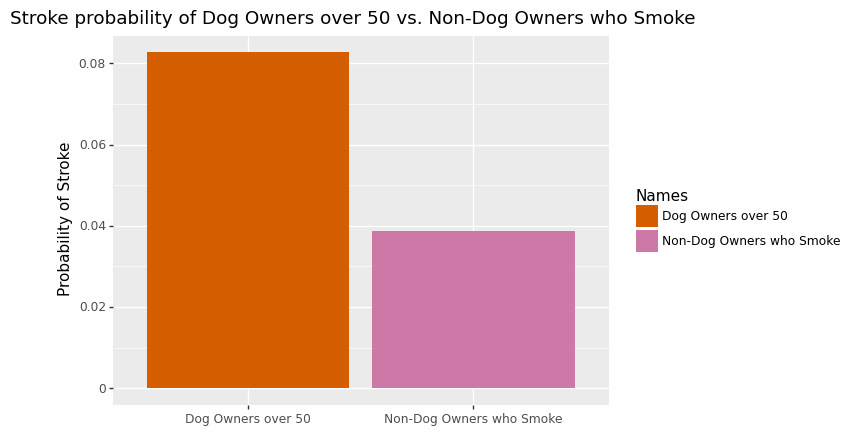

<ggplot: (8778494847581)>

In [174]:
#dog owners over 50 vs. non-dog owners who currently smoke
# P(Stroke|(dog & >50)) vs. P(Stroke|(!dog & smoke))
prop1 = ((db["stroke"] == True) & (db["dog_owner"] == True) & 
         (db["age"] > 50)).sum()/((db["dog_owner"] == True) & 
                                  (db["age"] >= 50)).sum()
prop2 = ((db["stroke"] == True) & (db["dog_owner"] == False) & 
         (db["smoking_status_smokes"] == True)).sum()/((db["dog_owner"] == False) 
         & (db["smoking_status_smokes"] == True)).sum()

data = pd.DataFrame({"Names": ["Dog Owners over 50", "Non-Dog Owners who Smoke"], 
                     "Probabilities": [prop1, prop2]})

(ggplot(data, aes(x = "Names", y = "Probabilities", fill = "Names")) + 
 geom_bar(stat = "identity") +
 scale_fill_manual(["#d55e00", "#cc79a7", "#0072b2","#f0e442","#009e73"]) +
 labs(title = "Stroke probability of Dog Owners over 50 vs. Non-Dog Owners who Smoke",
        x = "",
        y = "Probability of Stroke"))


This graph clearly shows the probability of dog owners over 50 and non-dog owners who smoke.  We are able to find these numbers using the basic probabiliy formulas of P(Stroke|(dog & >50)) and P(Stroke|(!dog & smoke) respectively.  We can then just directly compare them to see which has the better probability of a stroke.

2. What is the relationship between average blood glucose and BMI? Is the relationship between those two variables different for people who are and are not registered to vote? How can you tell?


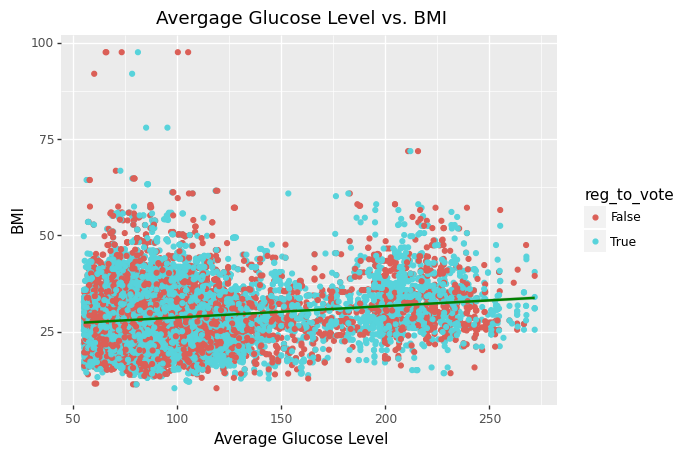

<ggplot: (8778492514129)>

In [175]:
part2_DB = pd.DataFrame({})
part2_DB["avg_glucose_level"] = db["avg_glucose_level"]
part2_DB["bmi"] = db["bmi"]
part2_DB["reg_to_vote"] = (db["reg_to_vote"] == True)

(ggplot(part2_DB, aes(x = "avg_glucose_level", y = "bmi", color = "reg_to_vote")) + 
 geom_point() +
 stat_smooth(method = "lm", color = "green") + 
 labs(title = "Avergage Glucose Level vs. BMI",
        x = "Average Glucose Level",
        y = "BMI"))

It looks like there is no clear difference between Average Glucose Level vs BMI based on if someone is registed to vote or not.  This makes sense because I don't believe registration to vote effects health.

3. Is your logistic regression model most accurate for people who make less than 30k, between 30-90k, or over 90k? Discuss the potential accuracy *and* ethical implications if your model *were* more accurate for different groups (you can use the full model from part I-3 to check accuracy for each of these groups; DO NOT create/fit new models for each income range, use the model from part I-3 to calculate the accuracy for each of these groups.)

1.0
0.9610494995942657
0.9547339322736696


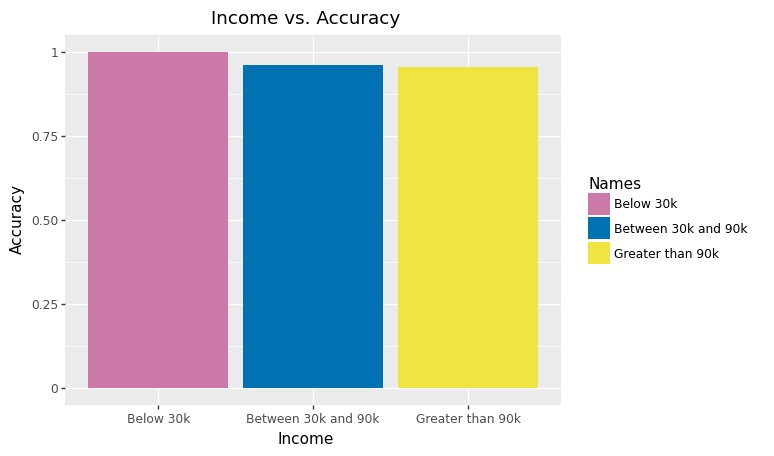

<ggplot: (8778492706369)>

In [176]:
Xn = pd.DataFrame({})
Xn["Model_Prediction"] = model2.predict(X2)
Xn["stroke"] = y2
Xn["accuracy"] = (Xn["stroke"] == Xn["Model_Prediction"])
Xn["income_cat"] = (db["income_in_k"] < 30)
Xn["income_cat"] = Xn["income_cat"] + ((db["income_in_k"] >= 30) & 
                                       (db["income_in_k"] <= 90))*2
Xn["income_cat"] = Xn["income_cat"] + (db["income_in_k"] > 90) * 3
below = (((Xn["income_cat"] == 1) & (Xn["accuracy"] == True)).sum() / 
         (Xn["income_cat"] == 1).sum())
inbetween = (((Xn["income_cat"] == 2) & (Xn["accuracy"] == True)).sum() / 
             (Xn["income_cat"] == 2).sum())
above = (((Xn["income_cat"] == 3) & (Xn["accuracy"] == True)).sum() / 
         (Xn["income_cat"] == 3).sum())

print(below)
print(inbetween)
print(above)

f = pd.DataFrame({"Names": ["Below 30k", "Between 30k and 90k", 
                            "Greater than 90k"], 
                     "Probabilities": [below, inbetween, above]})

(ggplot(f, aes(x = "Names", y = "Probabilities", fill = "Names")) + 
 geom_bar(stat = "identity") +
 scale_fill_manual(["#cc79a7", "#0072b2","#f0e442"]) +
 labs(title = "Income vs. Accuracy",
        x = "Income",
        y = "Accuracy"))

Yes.  It seems that our model is more inaccurate the higher someones income is.  This could lead to wealthier people not getting the potential assistance from doctors that they need to reduce strokes in the future.  Luckily we aren't using this model to actually predict strokes but if we were this would need to be adressed.

4. Which of the following variables is the strongest predictor of having a stroke (owning a dog, residence type, marriage, being registered to vote)? How were you able to tell?

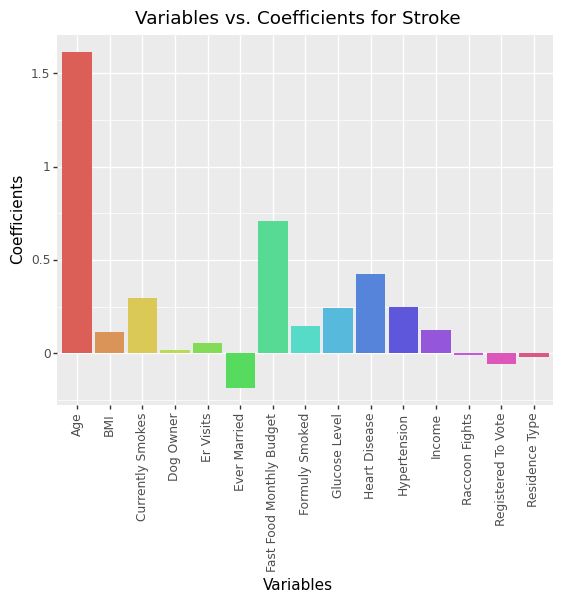

<ggplot: (8778491405217)>

In [177]:
x_labels = ["Registered To Vote",
        "Age", 
        "Hypertension", 
        "Heart Disease", 
        "Ever Married", 
        "Residence Type", 
        "Glucose Level", 
        "BMI", 
        "Currently Smokes", 
        "Formuly Smoked",
        "Dog Owner",
        "Er Visits",
        "Raccoon Fights",
        "Fast Food Monthly Budget",
        "Income"]
coef["Clean_Names"] = x_labels
(ggplot(coef, aes(x = "Clean_Names", y = "Coefs", fill = "Clean_Names" )) + 
 geom_bar(stat = "identity") +
 labs(title = "Variables vs. Coefficients for Stroke",
        x = "Variables",
        y = "Coefficients") +
 theme(axis_text_x = element_text(angle = 90),
     legend_position = "none"))

Age is the clearly the strongest indicator of an individuals likelihood of having a stroke.  For every 1 standard deviation increase in age there is a 1.61 increase in the logOdds of an individual having a stroke.  Fastfood is the second highest with 0.71 increase in logOdds per standard deviation.  Everthing else falls within 0.5 increase or decrease of logOdds.

5. Create a variable `er_visits_per_year` that calculates the # of visits to the ER that a person has had per year of life. Store this variable in your data frame (no need to include this variable in the previous logistic regression model). Is the # of ER visits per year different for stroke and non-stroke patients? How can you tell?

   stroke  er_visits_per_year
0   False            0.150000
1   False            1.250000
2   False            0.103896
3   False            0.216216
4   False            0.250000


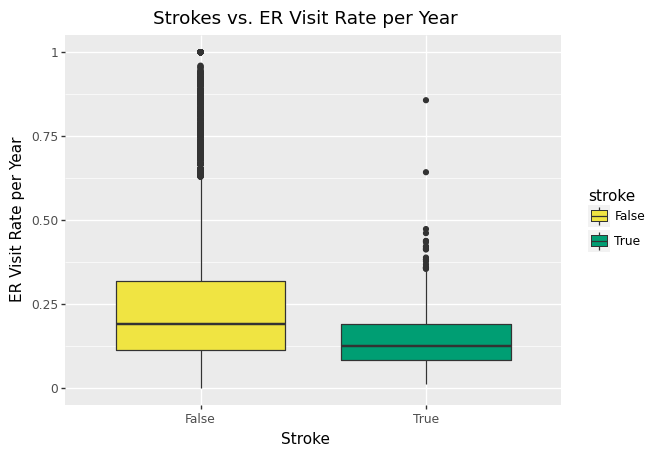

<ggplot: (8778491957701)>

In [178]:
ER_Rate  = pd.DataFrame({})
ER_Rate["stroke"] = (db["stroke"] == True)
ER_Rate["er_visits_per_year"] = db['er_visits']/db['age']
print(ER_Rate.head())

(ggplot(ER_Rate, aes(x = "stroke", y = "er_visits_per_year", fill = "stroke")) + 
 geom_boxplot() +
 scale_fill_manual(["#f0e442","#009e73"]) +
 ylim(0,1) +
 labs(title = "Strokes vs. ER Visit Rate per Year",
        x = "Stroke",
        y = "ER Visit Rate per Year"))

It seems that people who do not stroke have a lower ER visit rate per year than people who do stroke.  We can see this clearly in the fact that most Non-strokers  have a higher ER visit rate than Strokers.  Now, these numbers are extremely small so they may not mean much in view of a trend.

Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
